<a href="https://colab.research.google.com/github/tecgeoespaciales/Calidad-de-agua/blob/main/Cleaner_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
import missingno as msno
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')     # This will prompt for authorization.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importan los datos

https://www.statology.org/pandas-convert-boolean-to-int/

https://stackoverflow.com/questions/29960733/how-to-convert-true-false-values-in-dataframe-as-1-for-true-and-0-for-false

In [ ]:
def convert_dtype(x):
    if not x:
        return ''
    try:
        return int(x)
    except:
      if x == 'TRUE':
        return True
      elif x == 'FALSE':
        return False
      else:
        return str(x)

In [ ]:
df_2023_06_21 = pd.read_csv('/content/drive/MyDrive/Datos_PLC/Datos_2023-24/Clean_data/2023-06-21-Raw.dat', sep=' ', dtype={"Name": "string", "Time":"string"}, converters={'Value': convert_dtype})
#df_2024_02_07 = pd.read_csv('/content/drive/MyDrive/Datos_PLC/Datos_2023-24/Clean_data/2024-02-07-Raw.dat', sep=' ', dtype={"Name": "string", "Time":"string"}, converters={'Value': convert_dtype})
#df_2024_02_09 = pd.read_csv('/content/drive/MyDrive/Datos_PLC/Datos_2023-24/Clean_data/2024-02-09-Raw.dat', sep=' ', dtype={"Name": "string", "Time":"string"}, converters={'Value': convert_dtype})
#df_2024_02_14 = pd.read_csv('/content/drive/MyDrive/Datos_PLC/Datos_2023-24/Clean_data/2024-02-14-Raw.dat', sep=' ', dtype={"Name": "string", "Time":"string"}, converters={'Value': convert_dtype})
#df_2024_06_14 = pd.read_csv('/content/drive/MyDrive/Datos_PLC/Datos_2023-24/Clean_data/2024-06-14-Raw_10-20-30kW.dat', sep=' ', dtype={"Name": "string", "Time":"string"}, converters={'Value': convert_dtype})
#df_2024_08_13 = pd.read_csv('/content/drive/MyDrive/Datos_PLC/Datos_2023-24/Clean_data/2024-08-13-Raw.dat', sep=' ', dtype={"Name": "string", "Time":"string"}, converters={'Value': convert_dtype})

/tmp/ipython-input-350666290.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2023_06_21 = pd.read_csv('/content/drive/MyDrive/Datos_PLC/Datos_2023-24/Clean_data/2023-06-21-Raw.dat', sep=' ', dtype={"Name": "string", "Time":"string"}, converters={'Value': convert_dtype})


In [ ]:
C_2023_06_21 = pd.read_csv('/content/drive/MyDrive/Datos_PLC/Datos_2023-24/Clean_data/Comment-2023-06-21-Raw.txt', sep='\t', header = None)
#C_2024_02_07 = pd.read_csv('/content/drive/MyDrive/Datos_PLC/Datos_2023-24/Clean_data/Comment-2024-02-07-Raw.txt', sep='\t', header = None)
#C_2024_02_09 = pd.read_csv('/content/drive/MyDrive/Datos_PLC/Datos_2023-24/Clean_data/Comment-2024-02-09-Raw.txt', sep='\t', header = None)
#C_2024_02_14 = pd.read_csv('/content/drive/MyDrive/Datos_PLC/Datos_2023-24/Clean_data/Comment-2024-02-14-Raw.txt', sep='\t', header = None)
#C_2024_06_14 = pd.read_csv('/content/drive/MyDrive/Datos_PLC/Datos_2023-24/Clean_data/Comment-2024-06-14-Raw_10-20-30kW.txt', sep='\t', header = None)
#C_2024_08_13 = pd.read_csv('/content/drive/MyDrive/Datos_PLC/Datos_2023-24/Clean_data/Comment-2024-08-13-Raw.txt', sep='\t', header = None)

The `reduce(fun,seq)` function is used to apply a particular function passed in its argument to all of the list elements mentioned in the sequence passed along.

[Geek](https://www.geeksforgeeks.org/reduce-in-python/)

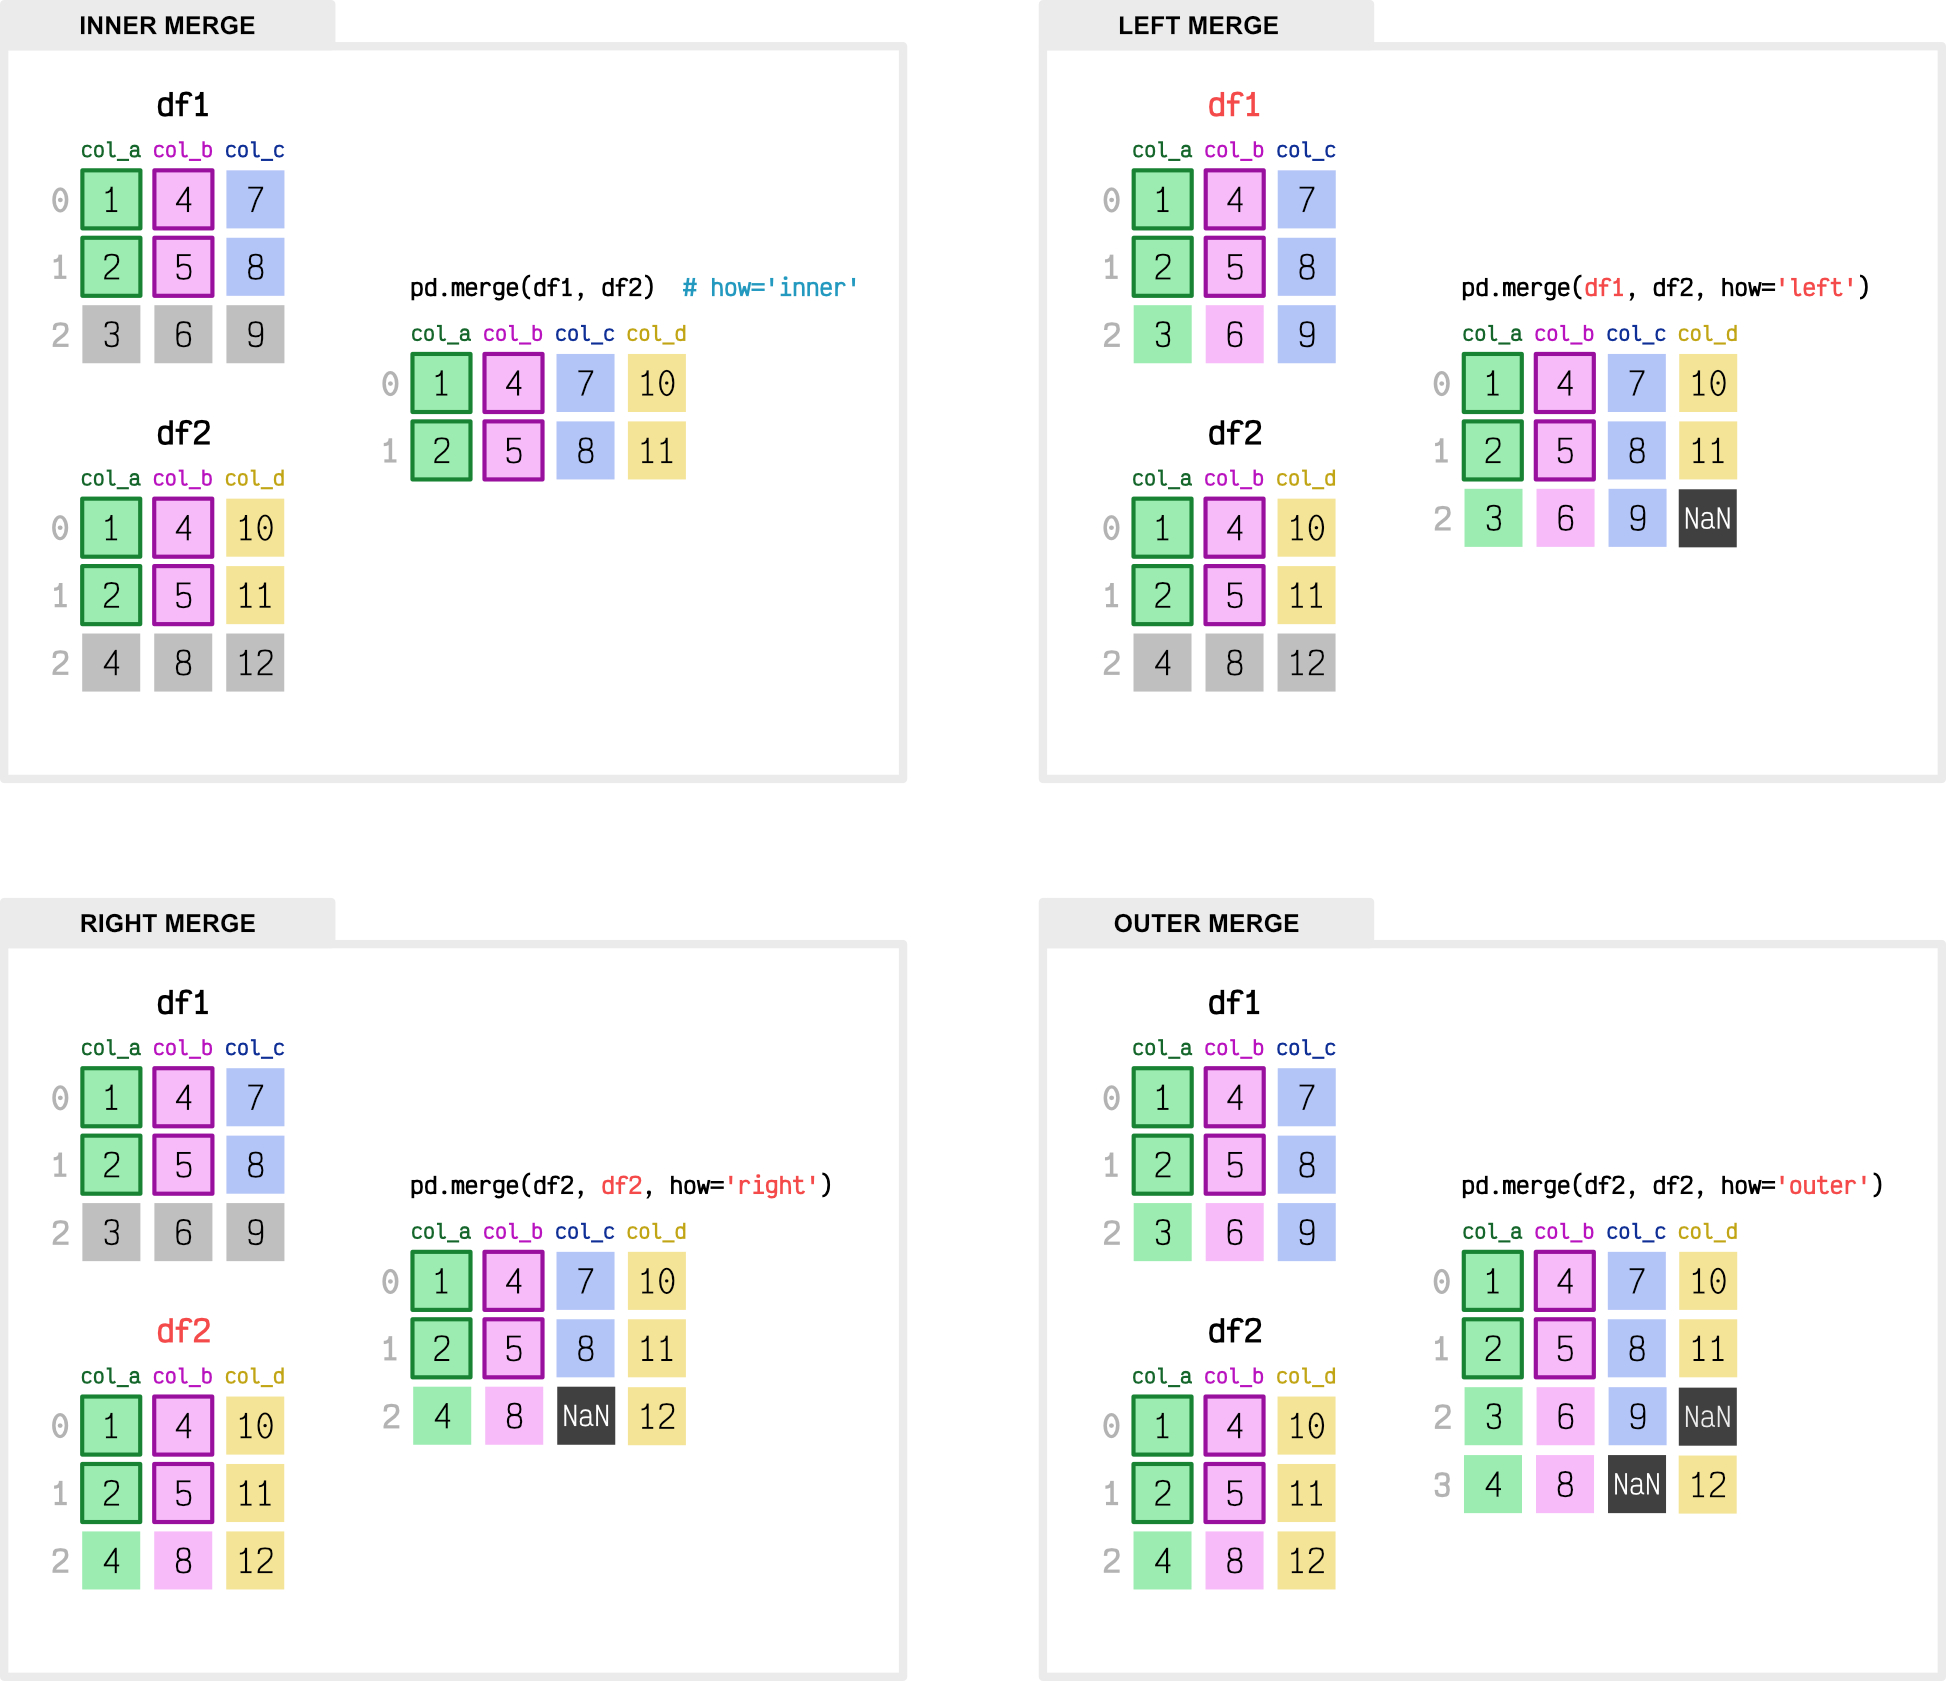

[reduce](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.insert.html)

#Crea un dataframe

Convierte los registros en una tabla

In [ ]:
def convert_table(datos, Comments):
  List1 = []
  Names = Comments.iloc[:,0].values
  for i in Names:
    mask = datos[datos['Name'] == i].copy()     # Selecciona solo las filas que coinciden con el Name
    mask.rename(columns = {'Value': i}, inplace = True)         # Renombra la columna Value con el Name
    mask.drop(labels="Name", axis=1, inplace = True)            # Descarta la columna "Name"
    List1.append(mask)
  return reduce(lambda  left,right: pd.merge(left,right,on='Time', how='outer'), List1)

In [ ]:
def reset_time(datos, fecha):
  Fecha = fecha
  datos['Time'] = Fecha + datos['Time']
  datos["Time"] = pd.to_datetime(datos["Time"], format='%d-%m-%Y %H:%M:%S.%f')
  T0 = datos['Time'].min()
  datos["Time"] = datos["Time"] - T0
  datos['Time'] = datos["Time"].apply(lambda x: x.total_seconds())
  datos.sort_values(by='Time', inplace=True)
  datos.reset_index(drop=True, inplace=True)
  return datos

In [ ]:
def Rod_Height(Barra):
  Barra = pd.DataFrame(Barra)
  Barra['mod'] = Barra.apply(lambda x: x%2**15)
  Barra['DiffP'] = Barra['mod'].diff().fillna(0)
  Barra['DiffN'] = -Barra['mod'].diff().fillna(0)
  Barra['Caso2'] = 0
  Barra['Altura'] = 0

  for i in range(1,len(Barra)):
    D_Forw = Barra.iloc[i,2]%2**15
    D_Back = Barra.iloc[i,3]%2**15

    if D_Forw < D_Back:
      Barra.iloc[i,4] = 1
      Barra.iloc[i,5] = Barra.iloc[i-1,5] + D_Forw

    else:
      Barra.iloc[i,4] = -1
      Barra.iloc[i,5] = Barra.iloc[i-1,5] - D_Back
  return Barra['Altura']

In [ ]:
Datos_2023_06_21 = convert_table(df_2023_06_21, C_2023_06_21)
Datos_2023_06_21 = reset_time(Datos_2023_06_21, '21-06-2023 ')
for i in ['%MW115', '%MW117', '%MW119']:
  Datos_2023_06_21[i] = Rod_Height(Datos_2023_06_21[i].dropna().astype('int').copy())

# Llenado de datos

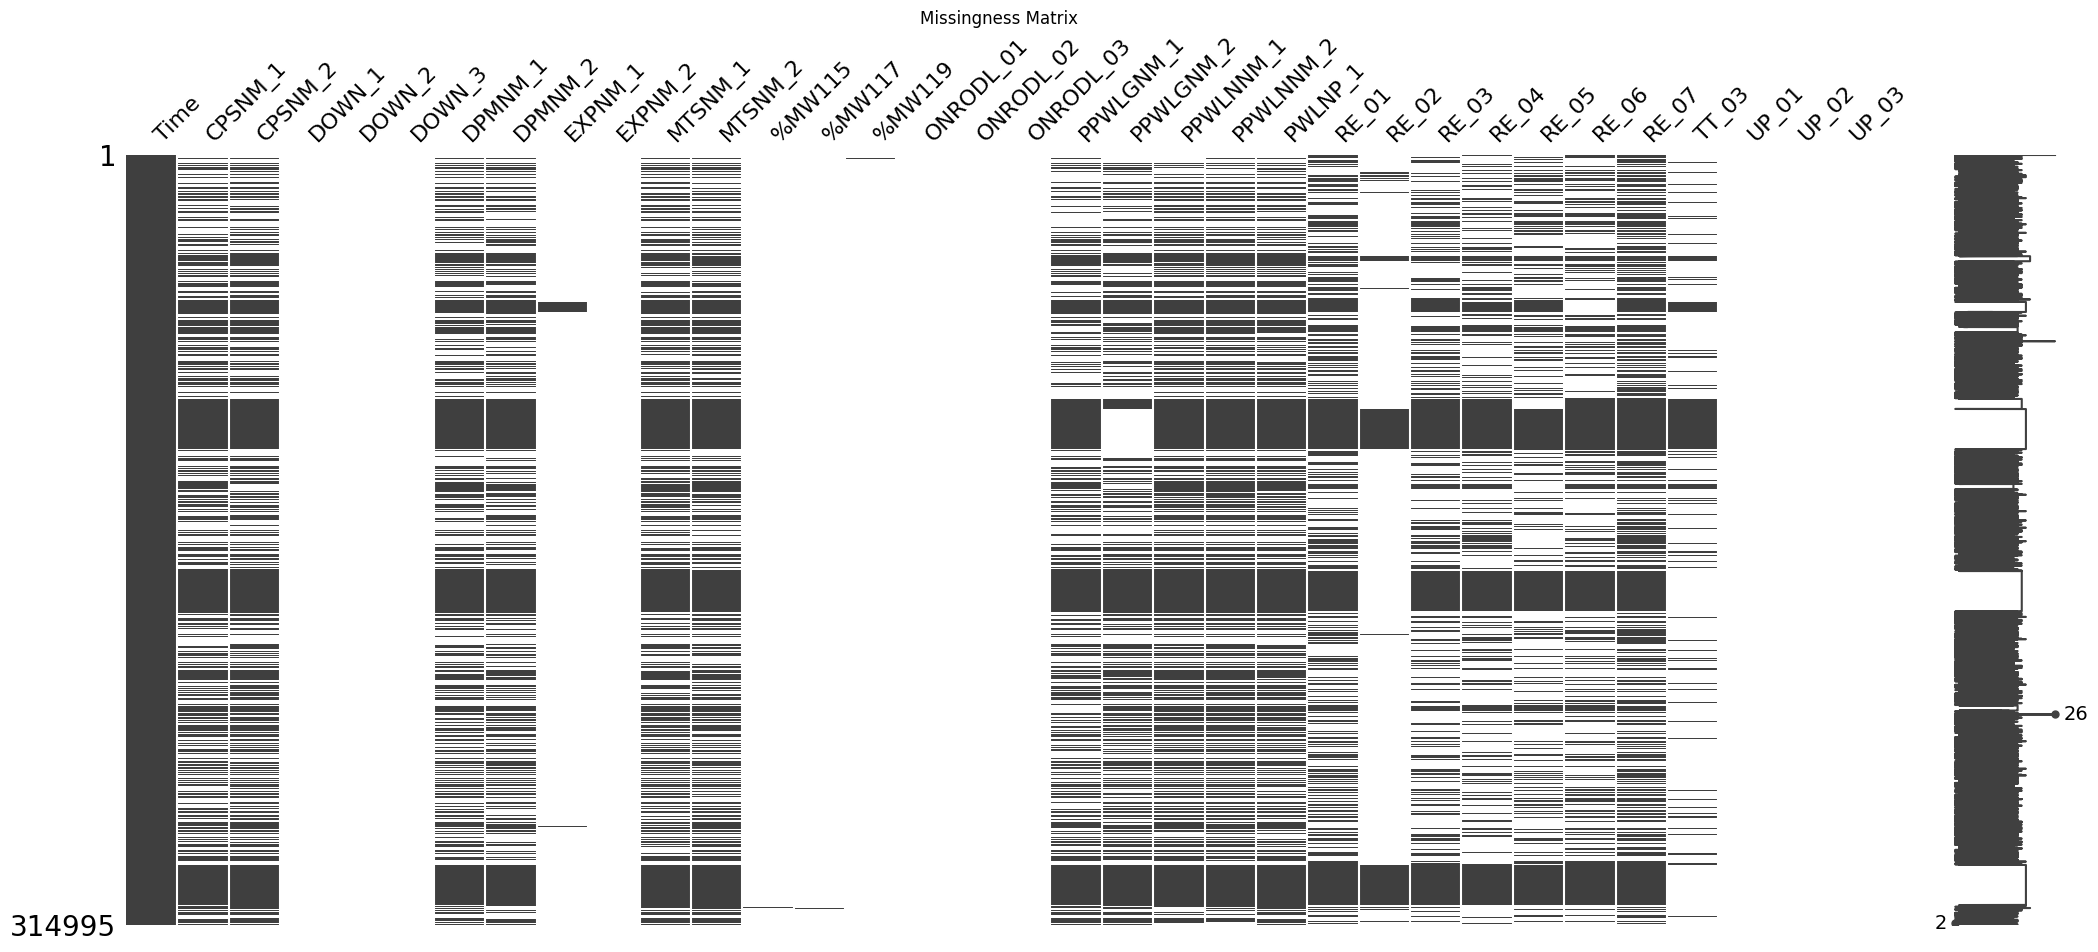

In [ ]:
msno.matrix(Datos_2023_06_21)
plt.title('Missingness Matrix')
plt.show()

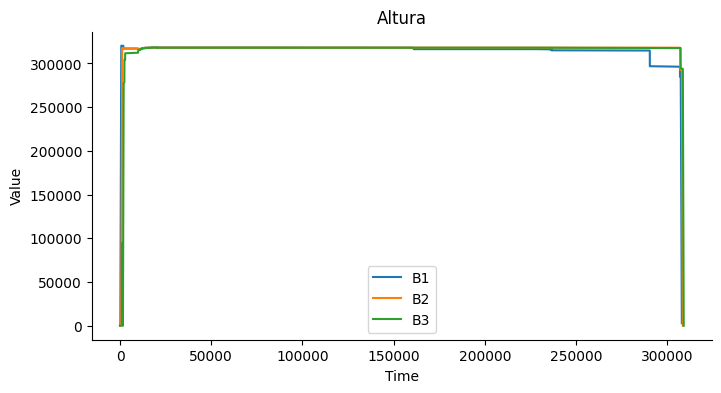

In [ ]:
Datos_2023_06_21['%MW115'].dropna().astype('int').plot(kind='line', figsize=(8, 4), label='B1')
Datos_2023_06_21['%MW117'].dropna().astype('int').plot(kind='line', figsize=(8, 4), label='B2')
Datos_2023_06_21['%MW119'].dropna().astype('int').plot(kind='line', figsize=(8, 4), label='B3')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Altura')
plt.legend()
plt.gca().spines[['top', 'right']].set_visible(False)#

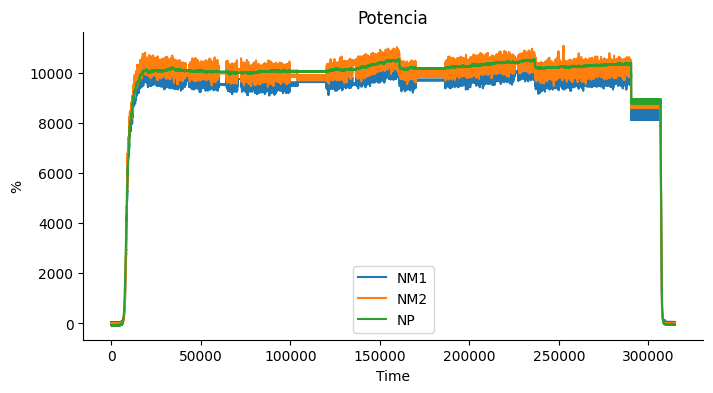

In [ ]:
Datos_2023_06_21['PPWLNNM_1'].dropna().astype('int').plot(kind='line', figsize=(8, 4), label='NM1')
Datos_2023_06_21['PPWLNNM_2'].dropna().astype('int').plot(kind='line', figsize=(8, 4), label='NM2')
Datos_2023_06_21['PWLNP_1'].dropna().astype('int').plot(kind='line', figsize=(8, 4), label='NP')
plt.xlabel('Time')
plt.ylabel('%')
plt.title('Potencia')
plt.legend()
plt.gca().spines[['top', 'right']].set_visible(False)#

In [ ]:
Datos_2023_06_21.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 314995 entries, 0 to 314994
Data columns (total 34 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Time       314995 non-null  float64
 1   CPSNM_1    171451 non-null  object 
 2   CPSNM_2    176898 non-null  object 
 3   DOWN_1     51 non-null      object 
 4   DOWN_2     19 non-null      object 
 5   DOWN_3     25 non-null      object 
 6   DPMNM_1    164341 non-null  object 
 7   DPMNM_2    165144 non-null  object 
 8   EXPNM_1    4768 non-null    object 
 9   EXPNM_2    24 non-null      object 
 10  MTSNM_1    177186 non-null  object 
 11  MTSNM_2    174113 non-null  object 
 12  %MW115     570 non-null     float64
 13  %MW117     543 non-null     float64
 14  %MW119     643 non-null     float64
 15  ONRODL_01  5 non-null       object 
 16  ONRODL_02  5 non-null       object 
 17  ONRODL_03  3 non-null       object 
 18  PPWLGNM_1  154122 non-null  object 
 19  PPWLGNM_2  142332 non-n

# Análisis de frecuencia

In [ ]:
df_test = Datos_2023_06_21.loc[:, ['Time', 'PPWLNNM_1', 'PPWLGNM_1', 'PPWLNNM_2', 'PPWLGNM_2', 'PWLNP_1']].copy()
df_test

,Time,PPWLNNM_1,PPWLGNM_1,PPWLNNM_2,PPWLGNM_2,PWLNP_1
0,0.00,51,10944,0,11167,-68
1,0.12,53,10947,NaN,11168,NaN
2,0.26,NaN,10945,-1,NaN,NaN
3,0.39,NaN,NaN,NaN,NaN,-67
4,0.53,52,10946,NaN,11167,NaN
...,...,...,...,...,...,...
314990,16061.21,NaN,NaN,NaN,NaN,NaN
314991,16061.34,NaN,NaN,NaN,NaN,NaN
314992,16061.46,NaN,NaN,NaN,NaN,NaN
314993,16061.57,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_PL1 = df_test.loc[:, ['Time', 'PPWLNNM_1']].copy().dropna()
df_PL1['Time'].diff().fillna(0)

,Time
0,0.00
1,0.12
4,0.41
6,0.24
7,0.14
...,...
314899,0.39
314901,0.12
314904,0.24
314906,0.14


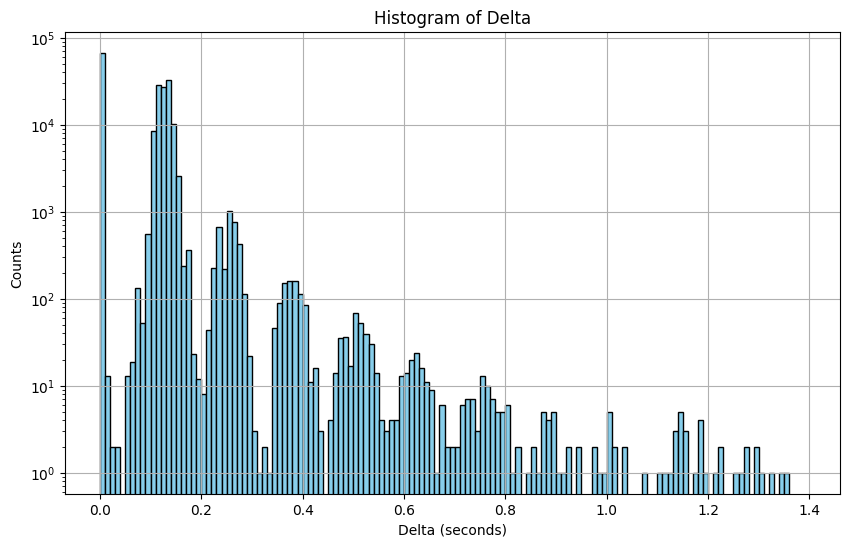

In [ ]:
Bins = np.arange(0.0, 1.4, 0.01).tolist()
data = df_PL1['Time'].diff().fillna(0)
plt.figure(figsize=(10, 6))

counts, t, patches = plt.hist(data, bins = Bins, color='skyblue', edgecolor='black', log=True)

plt.xlabel('Delta (seconds)')
plt.ylabel('Counts')
plt.title('Histogram of Delta')
plt.grid(True)
plt.show()

In [ ]:
result = np.zeros_like(counts, dtype=float) # Initialize with zeros or desired fill value
np.log10(counts, out=result, where=(counts != 0))
print(result)

[4.82905921 1.11394335 0.30103    0.30103    0.         1.11394335
 1.2787536  2.12057393 1.72427587 2.74896286 3.92957218 4.45589504
 4.43689381 4.51836915 4.00719282 3.40688067 2.372912   2.56466606
 1.36172784 1.07918125 0.90308999 1.64345268 2.35793485 2.82801506
 2.34044411 3.00689371 2.87794695 2.62634037 2.05690485 1.34242268
 0.47712125 0.         0.30103    0.         1.66275783 1.94939001
 2.18469143 2.19865709 2.20411998 2.05690485 1.92941893 1.04139269
 1.20411998 0.47712125 0.         0.60205999 1.14612804 1.54406804
 1.5563025  1.23044892 1.83884909 1.71600334 1.59106461 1.47712125
 1.14612804 0.60205999 0.47712125 0.60205999 0.60205999 1.11394335
 1.14612804 1.30103    1.38021124 1.20411998 1.04139269 0.95424251
 0.         0.77815125 0.30103    0.30103    0.30103    0.77815125
 0.84509804 0.84509804 0.47712125 1.11394335 1.         0.84509804
 0.69897    0.69897    0.77815125 0.         0.30103    0.
 0.         0.30103    0.         0.69897    0.60205999 0.69897
 0.   

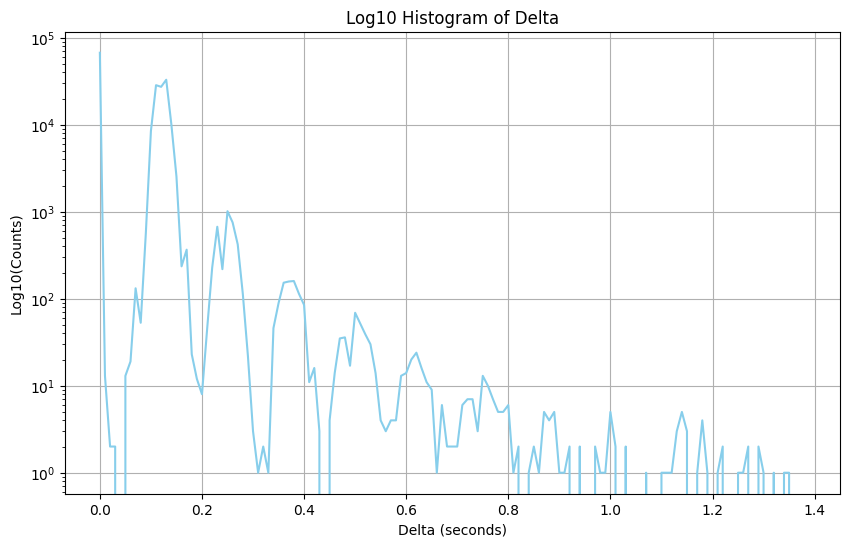

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(Bins[:-1], counts, color='skyblue')
plt.yscale('log')
plt.xlabel('Delta (seconds)')
plt.ylabel('Log10(Counts)')
plt.title('Log10 Histogram of Delta')
plt.grid(True)
plt.show()

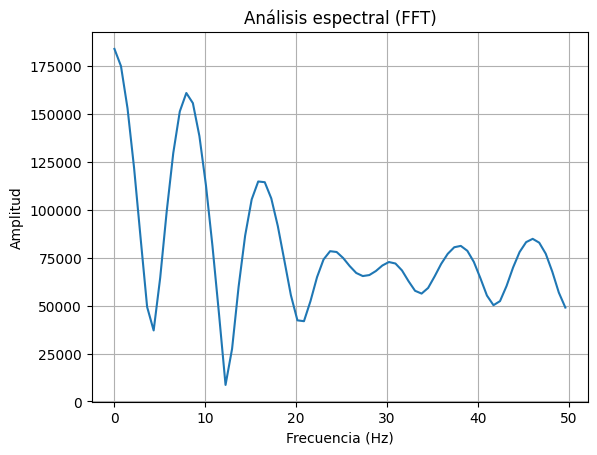

In [ ]:
# FFT
fft_result = np.fft.fft(counts)
frequencies = np.fft.fftfreq(len(Bins[:-1]), d=0.01)

# Graficar solo la mitad positiva del espectro
plt.plot(frequencies[:len(t)//2], np.abs(fft_result)[:len(t)//2])
plt.title("Análisis espectral (FFT)")
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Amplitud")
plt.grid(True)
plt.show()

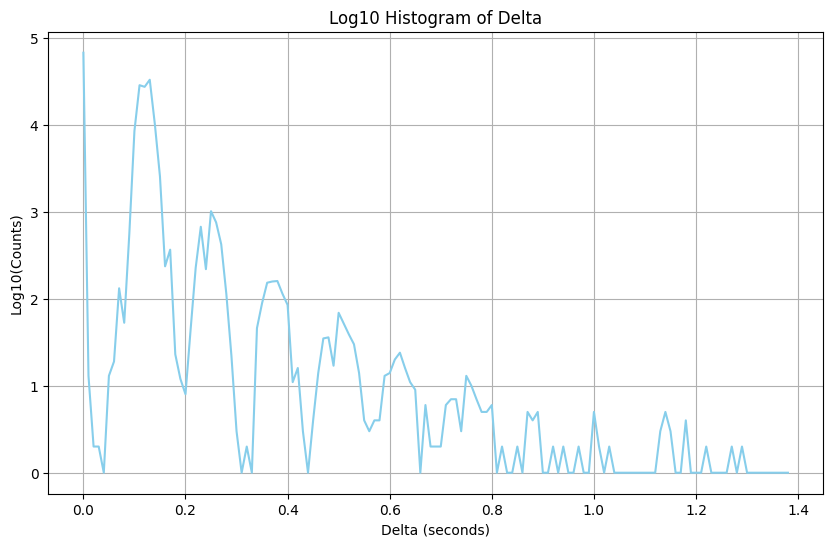

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(Bins[:-1], result, color='skyblue')

plt.xlabel('Delta (seconds)')
plt.ylabel('Log10(Counts)')
plt.title('Log10 Histogram of Delta')
plt.grid(True)
plt.show()

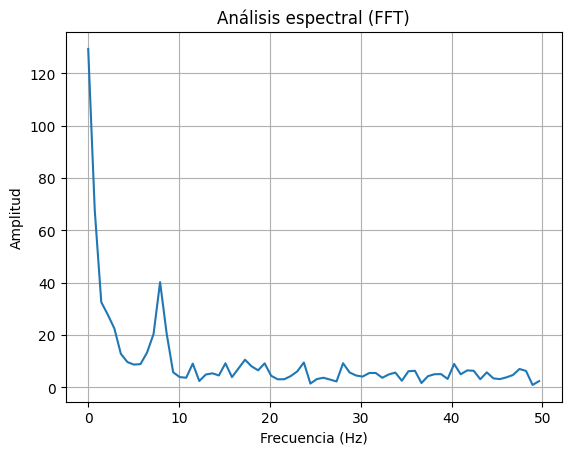

In [ ]:
# FFT
fft_result = np.fft.fft(result)
frequencies = np.fft.fftfreq(len(Bins[:-1]), d=0.01)

# Graficar solo la mitad positiva del espectro
plt.plot(frequencies[:len(t)//2], np.abs(fft_result)[:len(t)//2])
plt.title("Análisis espectral (FFT)")
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Amplitud")
plt.grid(True)
plt.show()

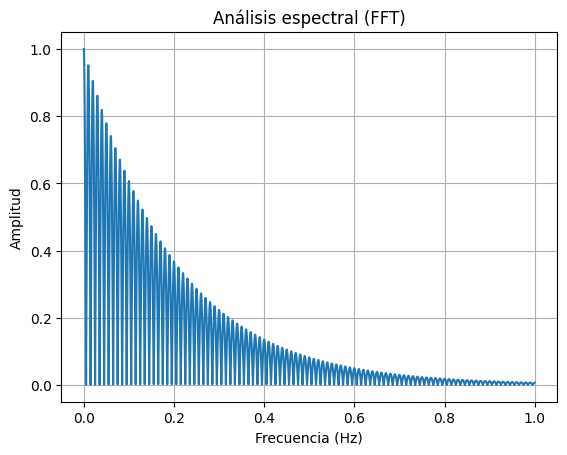

In [ ]:
t = np.linspace(0, 1, 10000)  # 1 segundo, 500 muestras
signal = np.exp(-5 * t) * np.abs(np.cos(2 * np.pi * 50 * t))  # frecuencia de 50 Hz amortiguada

# Graficar solo la mitad positiva del espectro
plt.plot(t, signal)
plt.title("Análisis espectral (FFT)")
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Amplitud")
plt.grid(True)
plt.show()

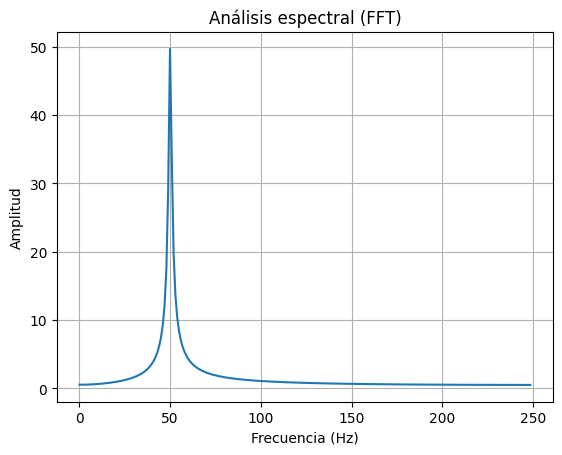

In [ ]:
# Simulamos una señal oscilatoria amortiguada
t = np.linspace(0, 1, 500)  # 1 segundo, 500 muestras
signal = np.exp(-5 * t) * np.cos(2 * np.pi * 50 * t)  # frecuencia de 50 Hz amortiguada

# FFT
fft_result = np.fft.fft(signal)
frequencies = np.fft.fftfreq(len(t), d=(t[1] - t[0]))

# Graficar solo la mitad positiva del espectro
#plt.plot(frequencies, fft_result)
plt.plot(frequencies[:len(t)//2], np.abs(fft_result)[:len(t)//2])
plt.title("Análisis espectral (FFT)")
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Amplitud")
plt.grid(True)
plt.show()

In [ ]:
for i in ['%MW115', '%MW117', '%MW119']:
  Datos_2023_06_21[i] = Rod_Height(Datos_2023_06_21[i].dropna().astype('int').copy())

In [ ]:
df_check = df_check.astype(float).ffill()
df_check = df_check.bfill()
df_check

,Time,%MW115,%MW117,%MW119,PPWLNNM_1,PPWLNNM_2
0,0.00,0.0,0.0,0.0,51.0,0.0
1,0.12,0.0,0.0,0.0,53.0,0.0
2,0.26,0.0,0.0,0.0,53.0,-1.0
3,0.39,0.0,0.0,0.0,53.0,-1.0
4,0.53,0.0,0.0,0.0,52.0,-1.0
...,...,...,...,...,...,...
314990,16061.21,2952.0,0.0,0.0,59.0,3.0
314991,16061.34,2952.0,0.0,0.0,59.0,3.0
314992,16061.46,2952.0,0.0,0.0,59.0,3.0
314993,16061.57,2952.0,0.0,0.0,59.0,3.0


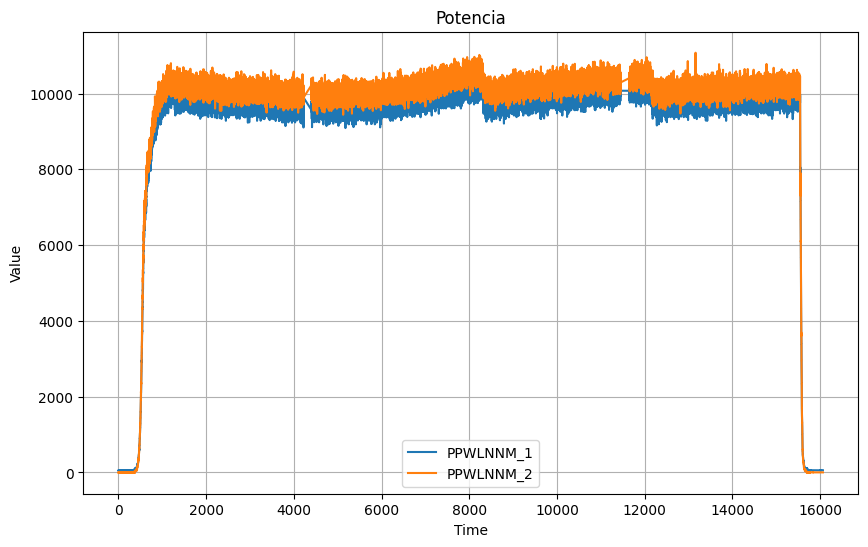

In [ ]:
# prompt: plot 'PPWLNNM_1', 'PPWLNNM_2' from df_check data frame

plt.figure(figsize=(10, 6))
plt.plot(df_check['Time'], df_check['PPWLNNM_1'], label='PPWLNNM_1')
plt.plot(df_check['Time'], df_check['PPWLNNM_2'], label='PPWLNNM_2')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Potencia')
plt.legend()
plt.grid(True)
plt.show()

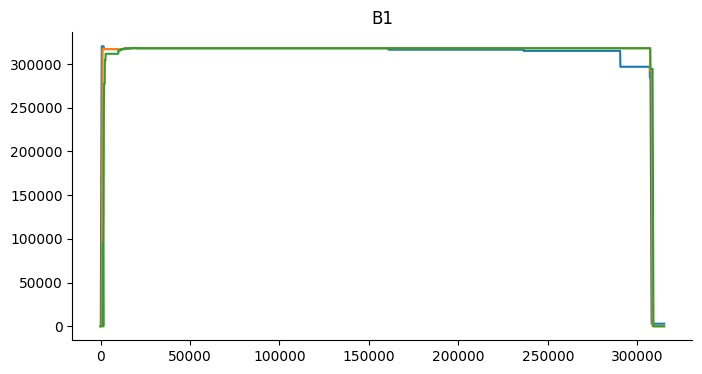

In [ ]:
B1['Acum'].plot(kind='line', figsize=(8, 4), title='B1')
B2['Acum'].plot(kind='line', figsize=(8, 4),)
B3['Acum'].plot(kind='line', figsize=(8, 4),)
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
def Move(A, B):
  if (-4000 < A < 0 and 0 < B < 4000) or (A > 28000 and B < -28000):   #Sube barra
    return 1
  elif (A < -28000 and B > 28000) or (0 < A < 4000 and -4000 < B < 0): #Baja barra
    return -1
  if (A < B):
    return 1
  else:
    return -1

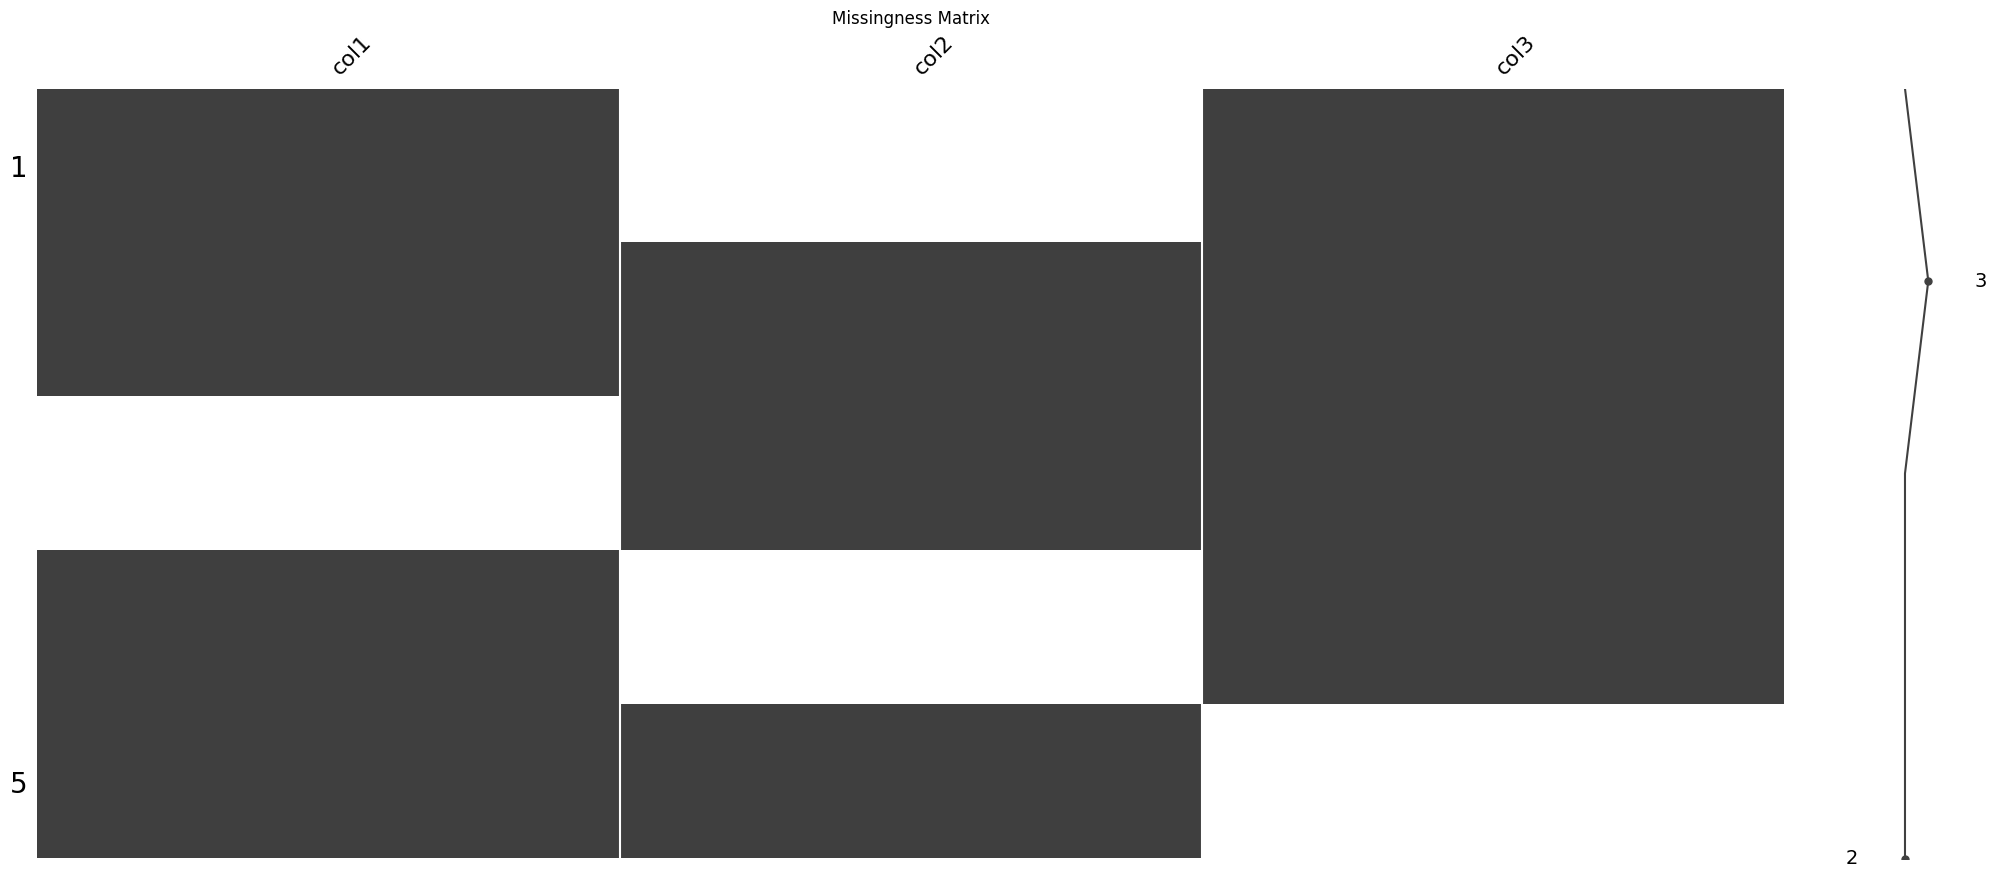

In [ ]:

import matplotlib.pyplot as plt

# Create a sample DataFrame with NaNs
data = {
    'col1': [1, 2, np.nan, 4, 5],
    'col2': [np.nan, 7, 8, np.nan, 10],
    'col3': [11, 12, 13, 14, np.nan]
    }
df = pd.DataFrame(data)

# Plot the missingness matrix
msno.matrix(df)
plt.title('Missingness Matrix')
plt.show()

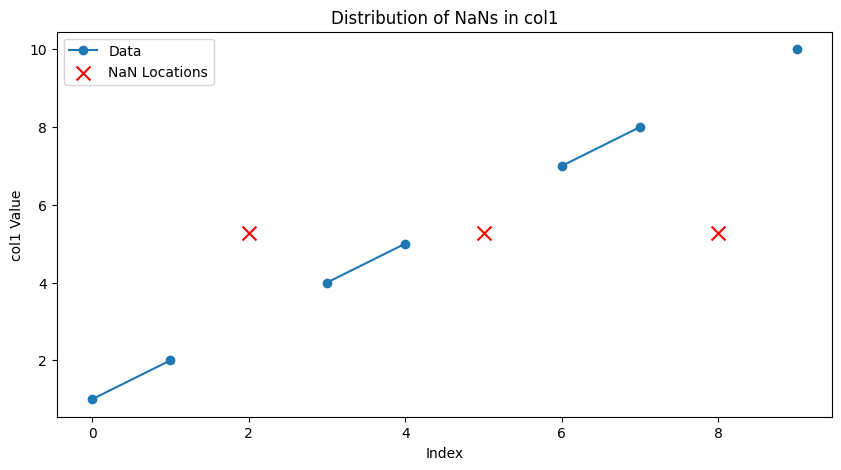

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Create a sample DataFrame with NaNs
data = {
    'col1': [1, 2, np.nan, 4, 5, np.nan, 7, 8, np.nan, 10],
    'index_val': range(10)
    }
df = pd.DataFrame(data)

# Identify NaN locations in 'col1'
nan_indices = df[df['col1'].isnull()].index

# Plot 'col1' with NaN locations highlighted
plt.figure(figsize=(10, 5))
plt.plot(df['index_val'], df['col1'], 'o-', label='Data')
# Plot NaN locations at a fixed y-coordinate (e.g., the minimum value of the data)
min_val = df['col1'].mean() if df['col1'].min() is not np.nan else 0 # Handle case where all values are NaN
plt.scatter(nan_indices, [min_val] * len(nan_indices), color='red', marker='x', s=100, label='NaN Locations')
plt.title('Distribution of NaNs in col1')
plt.xlabel('Index')
plt.ylabel('col1 Value')
plt.legend()
plt.show()

## Otras cosas

In [ ]:
def convert_high(df):
  df['mod16'] = df.iloc[:,0].apply(lambda x: x%2**15)
  df['Acum'] = 0
  for i in range(1,len(df)):
    Delta = df.iloc[i,1] - df.iloc[i-1,1]
    D_Forw = Delta%2**15
    D_Back = -Delta%2**15

    if D_Forw < D_Back:
      df.iloc[i,2] = df.iloc[i-1,2] + D_Forw
    else:
      df.iloc[i,2] = df.iloc[i-1,2] - D_Back
  return df['Acum']

In [ ]:
Altura1 = convert_high(Datos_2023_06_21[['%MW115']].dropna().astype('int'))
Altura2 = convert_high(Datos_2023_06_21[['%MW117']].dropna().astype('int'))
Altura3 = convert_high(Datos_2023_06_21[['%MW119']].dropna().astype('int'))

Datos_2023_06_21.insert(0, 'Altura_B1', Altura1)
Datos_2023_06_21.insert(1, 'Altura_B2', Altura2)
Datos_2023_06_21.insert(2, 'Altura_B3', Altura3)
Datos_2023_06_21.drop(columns=['%MW115', '%MW117','%MW119'],inplace = True)

In [ ]:
Datos_2023_06_21 = Datos_2023_06_21[['Time','PPWLNNM_1', 'MTSNM_1', 'EXPNM_1', 'PPWLGNM_1', 'CPSNM_1', 'DPMNM_1', 'PPWLNNM_2', 'MTSNM_2', 'EXPNM_2', 'PPWLGNM_2', 'CPSNM_2', 'DPMNM_2',
               'PWLNP_1', 'DOWN_1', 'UP_01', 'ONRODL_01', 'Altura_B1', 'DOWN_2', 'UP_02', 'ONRODL_02', 'Altura_B2', 'DOWN_3', 'UP_03', 'ONRODL_03', 'Altura_B3', 'RE_01',
               'RE_02', 'RE_03', 'RE_04', 'RE_05', 'RE_06', 'RE_07', 'TT_03']]

In [ ]:
Datos_2023_06_21.rename(columns={"PPWLNNM_1":"PLineal_1", "MTSNM_1":"PLManti_1", "EXPNM_1":"PLExpo_1", "PPWLGNM_1":"PLog_1", "CPSNM_1":"CPS-PLog_1", "DPMNM_1":"RDC_1",
                      "PPWLNNM_2":"PLineal_2", "MTSNM_2":"PLManti_2", "EXPNM_2":"PLExpo_2", "PPWLGNM_2":"PLog_2", "CPSNM_2":"CPS-PLog_2", "DPMNM_2":"RDC_2",
                      'PWLNP_1':"PLineal_NP", 'ONRODL_01':'Contacto_B1', 'ONRODL_02':'Contacto_B2', 'ONRODL_03':'Contacto_B3', 'RE_01':'M_Consola',
                      'RE_02':'M_Principal', 'RE_03':'M_Proces', 'RE_04':'H_Norte', 'RE_05':'H_Sur', 'RE_06':'M_Decaim', 'RE_07':'M_Boca', 'TT_03':'Temp' }, inplace=True)

In [ ]:
Datos_2023_06_21

,Time,PLineal_1,PLManti_1,PLExpo_1,PLog_1,CPS-PLog_1,RDC_1,PLineal_2,PLManti_2,PLExpo_2,...,Contacto_B3,Altura_B3,M_Consola,M_Principal,M_Proces,H_Norte,H_Sur,M_Decaim,M_Boca,Temp
0,0.00,51,2246,-4,10944,5345,-208,0,3251,-4,...,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.12,53,2247,NaN,10947,5338,-184,NaN,3250,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.26,NaN,2289,NaN,10945,NaN,-176,-1,3256,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.39,NaN,2287,NaN,NaN,5343,-172,NaN,3250,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.53,52,2289,NaN,10946,5344,-149,NaN,3212,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314990,16061.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,667,NaN,NaN,1143,NaN,NaN,9,244
314991,16061.34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,661,NaN,NaN,NaN,NaN,NaN,-5,NaN
314992,16061.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,660,NaN,NaN,NaN,739,NaN,-12,NaN
314993,16061.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,658,1240,NaN,NaN,707,NaN,5,243


In [ ]:
Datos_2023_06_21.info()

In [ ]:
Datos_2023_06_21.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 314995 entries, 0 to 314994
Data columns (total 34 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Time         314995 non-null  float64
 1   PLineal_1    183955 non-null  object 
 2   PLManti_1    177186 non-null  object 
 3   PLExpo_1     4768 non-null    object 
 4   PLog_1       154122 non-null  object 
 5   CPS-PLog_1   171451 non-null  object 
 6   RDC_1        164341 non-null  object 
 7   PLineal_2    186155 non-null  object 
 8   PLManti_2    174113 non-null  object 
 9   PLExpo_2     24 non-null      object 
 10  PLog_2       142332 non-null  object 
 11  CPS-PLog_2   176898 non-null  object 
 12  RDC_2        165144 non-null  object 
 13  PLineal_NP   182264 non-null  object 
 14  DOWN_1       51 non-null      object 
 15  UP_01        9 non-null       object 
 16  Contacto_B1  5 non-null       object 
 17  Altura_B1    570 non-null     float64
 18  DOWN_2       19 non-null

In [ ]:
Datos_2023_06_21.to_csv('2023-06-21-preprocesados.csv', index=False)

In [ ]:
!cp 2023-06-21-preprocesados.csv /content/drive/MyDrive/Datos_PLC/Datos_2023-24/Clean_data/

In [ ]:
List1 = []
Names = C_2024_02_07.iloc[:,0].values
for i in Names:
  mask = df_2024_02_07[df_2024_02_07['Name'] == i].copy()     # Selecciona solo las filas que coinciden con el Name
  mask.rename(columns = {'Value': i}, inplace = True)         # Renombra la columna Value con el Name
  mask.drop(labels="Name", axis=1, inplace = True)            # Descarta la columna "Name"
  List1.append(mask)
Datos_2024_02_07 = reduce(lambda  left,right: pd.merge(left,right,on='Time', how='outer'), List1)
Datos_2024_02_07.head(10)

,Time,CPSNM_1,CPSNM_2,DOWN_1,DOWN_2,DOWN_3,DPMNM_1,DPMNM_2,EXPNM_1,EXPNM_2,...,RE_05,RE_06,RE_07,TT_03,UP_01,UP_02,UP_03,ZLL_01,ZLL_02,ZLL_03
0,10:00:31.43,6121,5429,FALSE,FALSE,FALSE,-136,26,-4,-4,...,NaN,NaN,NaN,NaN,FALSE,FALSE,FALSE,TRUE,TRUE,TRUE
1,10:00:31.57,6118,5468,NaN,NaN,NaN,-164,15,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10:00:31.84,6160,NaN,NaN,NaN,NaN,-146,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10:00:31.98,6161,5433,NaN,NaN,NaN,-124,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10:00:32.09,6157,5431,NaN,NaN,NaN,-104,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,10:00:32.21,6160,5427,NaN,NaN,NaN,-97,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,10:00:32.49,6158,5432,NaN,NaN,NaN,-69,-19,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,10:00:32.63,6124,5428,NaN,NaN,NaN,-59,-24,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,10:00:32.75,6119,NaN,NaN,NaN,NaN,-57,-25,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10:00:32.90,6122,5427,NaN,NaN,NaN,-56,-20,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
List1 = []
Names = C_2024_02_09.iloc[:,0].values
for i in Names:
  mask = df_2024_02_09[df_2024_02_09['Name'] == i].copy()     # Selecciona solo las filas que coinciden con el Name
  mask.rename(columns = {'Value': i}, inplace = True)         # Renombra la columna Value con el Name
  mask.drop(labels="Name", axis=1, inplace = True)            # Descarta la columna "Name"
  List1.append(mask)
Datos_2024_02_09 = reduce(lambda  left,right: pd.merge(left,right,on='Time', how='outer'), List1)
Datos_2024_02_09.head(10)

,Time,CPSNM_1,CPSNM_2,DOWN_1,DOWN_2,DOWN_3,DPMNM_1,DPMNM_2,EXPNM_1,EXPNM_2,...,RE_02,RE_03,RE_04,RE_05,RE_06,RE_07,TT_03,ZLL_01,ZLL_02,ZLL_03
0,14:33:39.77,5850,5585,FALSE,FALSE,FALSE,-34,-66,-4,-4,...,NaN,NaN,NaN,654,863,10,NaN,TRUE,TRUE,TRUE
1,14:33:39.89,5846,5591,NaN,NaN,NaN,-23,-63,NaN,NaN,...,NaN,NaN,6,657,864,-5,NaN,NaN,NaN,NaN
2,14:33:40.01,5851,5588,NaN,NaN,NaN,-21,-62,NaN,NaN,...,NaN,NaN,NaN,658,NaN,5,202,NaN,NaN,NaN
3,14:33:40.14,5849,5583,NaN,NaN,NaN,NaN,-61,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,14:33:40.28,5847,5592,NaN,NaN,NaN,-20,-36,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,14:33:40.39,5844,5587,NaN,NaN,NaN,7,-18,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,14:33:40.53,5849,5584,NaN,NaN,NaN,15,3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,14:33:40.66,5852,5585,NaN,NaN,NaN,18,10,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,14:33:40.79,5847,5546,NaN,NaN,NaN,NaN,16,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,14:33:40.93,5890,5547,NaN,NaN,NaN,19,39,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
List1 = []
Names = C_2024_02_14.iloc[:,0].values
for i in Names:
  mask = df_2024_02_14[df_2024_02_14['Name'] == i].copy()     # Selecciona solo las filas que coinciden con el Name
  mask.rename(columns = {'Value': i}, inplace = True)         # Renombra la columna Value con el Name
  mask.drop(labels="Name", axis=1, inplace = True)            # Descarta la columna "Name"
  List1.append(mask)
Datos_2024_02_14 = reduce(lambda  left,right: pd.merge(left,right,on='Time', how='outer'), List1)
Datos_2024_02_14.head(10)

,Time,Aerosoles,CPSNM_1,CPSNM_2,DPMNM_1,DPMNM_2,EXPNM_1,EXPNM_2,FT_01,FT_02,...,RE_06,RE_07,TT_01,TT_02,TT_03,TT_04,TT_05,UP_01,UP_02,UP_03
0,10:11:55.36,20,NaN,NaN,NaN,NaN,NaN,NaN,6851,5773,...,7,10,186,168,205,196,182,NaN,NaN,NaN
1,11:13:36.51,20,NaN,NaN,NaN,NaN,NaN,NaN,2,0,...,653,31,182,174,200,191,181,NaN,NaN,NaN
2,10:12:05.59,NaN,6435,5356,46,67,-4,-4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FALSE,FALSE,FALSE
3,10:12:05.84,NaN,6471,5356,-52,76,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10:12:05.97,NaN,6430,5353,-80,60,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,10:12:06.09,NaN,6434,5352,-140,76,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,10:12:06.20,NaN,6437,5350,-171,84,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,10:12:06.32,NaN,6431,5348,-193,62,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,10:12:06.46,NaN,6473,5355,-222,55,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10:12:06.57,NaN,6510,5353,-238,52,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
List1 = []
Names = C_2024_06_14.iloc[:,0].values
for i in Names:
  mask = df_2024_06_14[df_2024_06_14['Name'] == i].copy()     # Selecciona solo las filas que coinciden con el Name
  mask.rename(columns = {'Value': i}, inplace = True)         # Renombra la columna Value con el Name
  mask.drop(labels="Name", axis=1, inplace = True)            # Descarta la columna "Name"
  List1.append(mask)
Datos_2024_06_14 = reduce(lambda  left,right: pd.merge(left,right,on='Time', how='outer'), List1)
Datos_2024_06_14.head(10)

,Time,CPSNM_1,CPSNM_2,DPMNM_1,DPMNM_2,EXPNM_1,EXPNM_2,MTSNM_1,MTSNM_2,%MW115,...,PPWLNNM_2,PWLNP_1,RE_01,RE_02,RE_03,RE_04,RE_05,RE_06,RE_07,TT_03
0,15:42:00.15,6241.0,5895.0,-22.0,166.0,-4.0,-4.0,6544.0,4573.0,0.0,...,-2.0,-68.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,15:42:00.28,6237.0,5893.0,-37.0,161.0,NaN,NaN,6546.0,4571.0,NaN,...,NaN,-69.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,15:42:00.41,6236.0,5898.0,-55.0,135.0,NaN,NaN,6541.0,4575.0,NaN,...,NaN,-68.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,15:42:00.55,6238.0,5894.0,-84.0,126.0,NaN,NaN,NaN,4572.0,NaN,...,-1.0,-70.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,15:42:00.68,6195.0,5896.0,-93.0,123.0,NaN,NaN,6543.0,4573.0,NaN,...,-2.0,-71.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,15:42:00.80,6200.0,5897.0,-95.0,99.0,NaN,NaN,6507.0,4612.0,NaN,...,NaN,-69.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,15:42:00.95,6199.0,5895.0,-120.0,90.0,NaN,NaN,6501.0,4615.0,NaN,...,NaN,-64.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,15:42:01.08,6203.0,5896.0,-128.0,87.0,NaN,NaN,NaN,4617.0,NaN,...,NaN,-70.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,15:42:01.21,6236.0,5891.0,-130.0,85.0,NaN,NaN,6498.0,4611.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,15:42:01.33,6238.0,5896.0,-103.0,86.0,NaN,NaN,NaN,4616.0,NaN,...,-1.0,-69.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
List1 = []
Names = C_2024_08_13.iloc[:,0].values
for i in Names:
  mask = df_2024_08_13[df_2024_08_13['Name'] == i].copy()     # Selecciona solo las filas que coinciden con el Name
  mask.rename(columns = {'Value': i}, inplace = True)         # Renombra la columna Value con el Name
  mask.drop(labels="Name", axis=1, inplace = True)            # Descarta la columna "Name"
  List1.append(mask)
Datos_2024_08_13 = reduce(lambda  left,right: pd.merge(left,right,on='Time', how='outer'), List1)
Datos_2024_08_13.head(10)

,Time,CPSNM_1,CPSNM_2,DPMNM_1,DPMNM_2,EXPNM_1,EXPNM_2,MTSNM_1,MTSNM_2,%MW115,...,TRIPROD_02,TRIPROD_03,TT_01,TT_03,ZLH_01,ZLH_02,ZLH_03,ZLL_01,ZLL_02,ZLL_03
0,9:47:28.92,6663,5814,-183,19,-3,-4,1080,4189,0,...,FALSE,FALSE,NaN,NaN,FALSE,FALSE,FALSE,TRUE,TRUE,TRUE
1,9:47:29.04,6665,5821,-173,15,NaN,NaN,1081,4188,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9:47:29.15,6662,5816,-172,-3,NaN,NaN,1076,4189,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9:47:29.26,6625,5814,NaN,-14,NaN,NaN,1074,4190,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9:47:29.38,6628,5818,-171,-40,NaN,NaN,1079,4189,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,9:47:29.52,6629,5781,NaN,-55,NaN,NaN,1076,4186,144,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,9:47:29.65,6587,5777,NaN,-60,NaN,NaN,NaN,4190,828,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,9:47:29.79,6591,5815,-170,-61,NaN,NaN,1079,4191,1836,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9:47:29.92,6549,5782,-191,-65,NaN,NaN,1040,4190,2844,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9:47:30.06,6511,5778,-214,-87,NaN,NaN,1036,4187,4392,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Operación del 07/02/2024

In [ ]:
Fecha = '07-02-2024 '
Datos_2024_02_07['Time'] = Fecha + Datos_2024_02_07['Time']
Datos_2024_02_07["Time"] = pd.to_datetime(Datos_2024_02_07["Time"], format='%d-%m-%Y %H:%M:%S.%f')
T0 = Datos_2024_02_07['Time'].min()
T0

Timestamp('2024-02-07 10:00:31.430000')

In [ ]:
Datos_2024_02_07["Time"] = Datos_2024_02_07["Time"] - T0
Datos_2024_02_07['Time'] = Datos_2024_02_07["Time"].apply(lambda x: x.total_seconds())
Datos_2024_02_07['Time']

,Time
0,0.00
1,0.14
2,0.41
3,0.55
4,0.66
...,...
292018,15244.85
292019,15248.28
292020,15346.87
292021,2013.80


In [ ]:
Datos_2024_02_07.sort_values(by='Time', inplace=True)
Datos_2024_02_07.reset_index(drop=True, inplace=True)
Datos_2024_02_07

,Time,CPSNM_1,CPSNM_2,DOWN_1,DOWN_2,DOWN_3,DPMNM_1,DPMNM_2,EXPNM_1,EXPNM_2,...,RE_05,RE_06,RE_07,TT_03,UP_01,UP_02,UP_03,ZLL_01,ZLL_02,ZLL_03
0,0.00,6121,5429,FALSE,FALSE,FALSE,-136,26,-4,-4,...,NaN,NaN,NaN,NaN,FALSE,FALSE,FALSE,TRUE,TRUE,TRUE
1,0.14,6118,5468,NaN,NaN,NaN,-164,15,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.27,NaN,5431,NaN,NaN,NaN,-168,13,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.41,6160,NaN,NaN,NaN,NaN,-146,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.55,6161,5433,NaN,NaN,NaN,-124,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292018,15380.49,9989,9947,NaN,NaN,NaN,-645,-504,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
292019,15380.60,9988,9949,NaN,NaN,NaN,-646,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
292020,15380.74,9989,9947,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
292021,15380.87,9986,9949,NaN,NaN,NaN,NaN,-520,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Altura de barra

In [ ]:
Altura1 = convert_high(Datos_2024_02_07[['%MW115']].dropna().astype('int'))
Altura2 = convert_high(Datos_2024_02_07[['%MW117']].dropna().astype('int'))
Altura3 = convert_high(Datos_2024_02_07[['%MW119']].dropna().astype('int'))

Datos_2024_02_07.insert(0, 'Altura_B1', Altura1)
Datos_2024_02_07.insert(1, 'Altura_B2', Altura2)
Datos_2024_02_07.insert(2, 'Altura_B3', Altura3)
Datos_2024_02_07.drop(columns=['%MW115', '%MW117','%MW119'],inplace = True)

In [ ]:
Datos_2024_02_07 = Datos_2024_02_07[['Time','PPWLNNM_1', 'MTSNM_1', 'EXPNM_1', 'PPWLGNM_1', 'CPSNM_1', 'DPMNM_1', 'PPWLNNM_2', 'MTSNM_2', 'EXPNM_2', 'PPWLGNM_2', 'CPSNM_2', 'DPMNM_2',
                                     'PWLNP_1', 'DOWN_1', 'UP_01', 'ZLL_01', 'Altura_B1', 'DOWN_2', 'UP_02', 'ZLL_02', 'Altura_B2', 'DOWN_3', 'UP_03', 'ZLL_03', 'Altura_B3', 'RE_01',
                                     'RE_02', 'RE_03', 'RE_04', 'RE_05', 'RE_06', 'RE_07', 'TT_03']]

In [ ]:
Datos_2024_02_07.rename(columns={"PPWLNNM_1":"PLineal_1", "MTSNM_1":"PLManti_1", "EXPNM_1":"PLExpo_1", "PPWLGNM_1":"PLog_1", "CPSNM_1":"CPS-PLog_1", "DPMNM_1":"RDC_1",
                      "PPWLNNM_2":"PLineal_2", "MTSNM_2":"PLManti_2", "EXPNM_2":"PLExpo_2", "PPWLGNM_2":"PLog_2", "CPSNM_2":"CPS-PLog_2", "DPMNM_2":"RDC_2",
                      'PWLNP_1':"PLineal_NP", 'ZLL_01':'LimiteI_B1', 'ZLL_02':'LimiteI_B2', 'ZLL_03':'LimiteI_B3', 'RE_01':'M_Consola',
                      'RE_02':'M_Principal', 'RE_03':'M_Proces', 'RE_04':'H_Norte', 'RE_05':'H_Sur', 'RE_06':'M_Decaim', 'RE_07':'M_Boca', 'TT_03':'Temp' }, inplace=True)

In [ ]:
Datos_2024_02_07

,Time,PLineal_1,PLManti_1,PLExpo_1,PLog_1,CPS-PLog_1,RDC_1,PLineal_2,PLManti_2,PLExpo_2,...,LimiteI_B3,Altura_B3,M_Consola,M_Principal,M_Proces,H_Norte,H_Sur,M_Decaim,M_Boca,Temp
0,0.00,52,5838,-4,11572,6121,-136,-2,2629,-4,...,TRUE,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.14,53,5836,NaN,11571,6118,-164,NaN,2667,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.27,54,5839,NaN,11572,NaN,-168,NaN,2664,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.41,NaN,5842,NaN,11614,6160,-146,NaN,2669,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.55,NaN,5877,NaN,11630,6161,-124,NaN,2682,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292018,15380.49,NaN,4522,NaN,16177,9989,-645,44,4661,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
292019,15380.60,NaN,4523,NaN,16141,9988,-646,46,4656,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
292020,15380.74,115,4488,NaN,16160,9989,NaN,NaN,4654,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
292021,15380.87,NaN,4487,NaN,16184,9986,NaN,NaN,4616,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
Datos_2024_02_07.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292023 entries, 0 to 292022
Data columns (total 34 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Time         292023 non-null  float64
 1   PLineal_1    164502 non-null  object 
 2   PLManti_1    156280 non-null  object 
 3   PLExpo_1     364 non-null     object 
 4   PLog_1       136180 non-null  object 
 5   CPS-PLog_1   152525 non-null  object 
 6   RDC_1        145375 non-null  object 
 7   PLineal_2    166586 non-null  object 
 8   PLManti_2    152492 non-null  object 
 9   PLExpo_2     10 non-null      object 
 10  PLog_2       141003 non-null  object 
 11  CPS-PLog_2   158657 non-null  object 
 12  RDC_2        128854 non-null  object 
 13  PLineal_NP   162716 non-null  object 
 14  DOWN_1       1 non-null       object 
 15  UP_01        79 non-null      object 
 16  LimiteI_B1   3 non-null       object 
 17  Altura_B1    639 non-null     float64
 18  DOWN_2       5 non-null 

In [ ]:
Datos_2024_02_07.to_csv('2024-02-07-preprocesados.csv', index=False)

## Operación del 09/02/2024

In [ ]:
Fecha = '09-02-2024 '
Datos_2024_02_09['Time'] = Fecha + Datos_2024_02_09['Time']
Datos_2024_02_09["Time"] = pd.to_datetime(Datos_2024_02_09["Time"], format='%d-%m-%Y %H:%M:%S.%f')
T0 = Datos_2024_02_09['Time'].min()
T0

Timestamp('2024-02-09 14:33:28.430000')

In [ ]:
Datos_2024_02_09["Time"] = Datos_2024_02_09["Time"] - T0
Datos_2024_02_09['Time'] = Datos_2024_02_09["Time"].apply(lambda x: x.total_seconds())
Datos_2024_02_09['Time']

0           11.34
1           11.46
2           11.58
3           11.71
4           11.85
           ...   
170895    9691.42
170896    9691.54
170897    9693.67
170898    5697.05
170899    8017.32
Name: Time, Length: 170900, dtype: float64

In [ ]:
Datos_2024_02_09.sort_values(by='Time', inplace=True)
Datos_2024_02_09.reset_index(drop=True, inplace=True)
Datos_2024_02_09

,Time,CPSNM_1,CPSNM_2,DOWN_1,DOWN_2,DOWN_3,DPMNM_1,DPMNM_2,EXPNM_1,EXPNM_2,...,RE_02,RE_03,RE_04,RE_05,RE_06,RE_07,TT_03,ZLL_01,ZLL_02,ZLL_03
0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4,663,563,280,7,24,203,NaN,NaN,NaN
1,0.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,564,NaN,NaN,0,NaN,NaN,NaN,NaN
2,0.23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-7,NaN,NaN,NaN,NaN
3,0.34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,896,NaN,NaN,NaN,13,NaN,NaN,NaN,NaN
4,0.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1096,565,NaN,NaN,22,204,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170895,9703.87,7487,7259,NaN,NaN,NaN,-291,-394,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
170896,9704.02,7486,7263,NaN,NaN,NaN,-281,-369,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
170897,9704.15,7529,7262,NaN,NaN,NaN,-257,-359,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
170898,9704.26,7487,7261,NaN,NaN,NaN,-245,-358,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Altura de barra

In [ ]:
Altura1 = convert_high(Datos_2024_02_09[['%MW115']].dropna().astype('int'))
Altura2 = convert_high(Datos_2024_02_09[['%MW117']].dropna().astype('int'))
Altura3 = convert_high(Datos_2024_02_09[['%MW119']].dropna().astype('int'))

Datos_2024_02_09.insert(0, 'Altura_B1', Altura1)
Datos_2024_02_09.insert(1, 'Altura_B2', Altura2)
Datos_2024_02_09.insert(2, 'Altura_B3', Altura3)
Datos_2024_02_09.drop(columns=['%MW115', '%MW117','%MW119'],inplace = True)

In [ ]:
Datos_2024_02_09 = Datos_2024_02_09[['Time','PPWLNNM_1', 'MTSNM_1', 'EXPNM_1', 'PPWLGNM_1', 'CPSNM_1', 'DPMNM_1', 'PPWLNNM_2', 'MTSNM_2', 'EXPNM_2', 'PPWLGNM_2', 'CPSNM_2', 'DPMNM_2',
                                     'PWLNP_1', 'DOWN_1', 'ONRODL_01', 'ZLL_01', 'Altura_B1', 'DOWN_2', 'ONRODL_02', 'ZLL_02', 'Altura_B2', 'DOWN_3', 'ONRODL_03', 'ZLL_03', 'Altura_B3', 'RE_01',
                                     'RE_02', 'RE_03', 'RE_04', 'RE_05', 'RE_06', 'RE_07', 'TT_03']]

In [ ]:
Datos_2024_02_09.rename(columns={"PPWLNNM_1":"PLineal_1", "MTSNM_1":"PLManti_1", "EXPNM_1":"PLExpo_1", "PPWLGNM_1":"PLog_1", "CPSNM_1":"CPS-PLog_1", "DPMNM_1":"RDC_1",
                      "PPWLNNM_2":"PLineal_2", "MTSNM_2":"PLManti_2", "EXPNM_2":"PLExpo_2", "PPWLGNM_2":"PLog_2", "CPSNM_2":"CPS-PLog_2", "DPMNM_2":"RDC_2",
                      'PWLNP_1':"PLineal_NP", 'ONRODL_01':'Contacto_B1', 'ZLL_01':'LimiteI_B1', 'ONRODL_01':'Contacto_B1', 'ZLL_02':'LimiteI_B2', 'ZLL_03':'LimiteI_B3', 'RE_01':'M_Consola', 'RE_02':'M_Principal',
                      'RE_03':'M_Proces', 'RE_04':'H_Norte', 'RE_05':'H_Sur', 'RE_06':'M_Decaim', 'RE_07':'M_Boca', 'TT_03':'Temp' }, inplace=True)

In [ ]:
Datos_2024_02_09

,Time,PLineal_1,PLManti_1,PLExpo_1,PLog_1,CPS-PLog_1,RDC_1,PLineal_2,PLManti_2,PLExpo_2,...,LimiteI_B3,Altura_B3,M_Consola,M_Principal,M_Proces,H_Norte,H_Sur,M_Decaim,M_Boca,Temp
0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3,4,663,563,280,7,24,203
1,0.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,564,NaN,NaN,0,NaN
2,0.23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,-7,NaN
3,0.34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2,NaN,896,NaN,NaN,NaN,13,NaN
4,0.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,1096,565,NaN,NaN,22,204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170895,9703.87,59,2796,NaN,12692,7487,-291,NaN,2243,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
170896,9704.02,58,2801,NaN,12697,7486,-281,NaN,2245,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
170897,9704.15,59,2835,NaN,12698,7529,-257,NaN,2242,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
170898,9704.26,NaN,2840,NaN,12696,7487,-245,NaN,2243,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
Datos_2024_02_09.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170900 entries, 0 to 170899
Data columns (total 34 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Time         170900 non-null  float64
 1   PLineal_1    76074 non-null   object 
 2   PLManti_1    85600 non-null   object 
 3   PLExpo_1     24 non-null      object 
 4   PLog_1       69592 non-null   object 
 5   CPS-PLog_1   82493 non-null   object 
 6   RDC_1        78621 non-null   object 
 7   PLineal_2    77551 non-null   object 
 8   PLManti_2    85839 non-null   object 
 9   PLExpo_2     146 non-null     object 
 10  PLog_2       77764 non-null   object 
 11  CPS-PLog_2   86618 non-null   object 
 12  RDC_2        78030 non-null   object 
 13  PLineal_NP   87067 non-null   object 
 14  DOWN_1       35 non-null      object 
 15  Contacto_B1  2 non-null       object 
 16  LimiteI_B1   3 non-null       object 
 17  Altura_B1    1147 non-null    float64
 18  DOWN_2       49 non-null

In [ ]:
Datos_2024_02_09.to_csv('2024-02-09-preprocesados.csv', index=False)

## Operación del 14/02/2024

In [ ]:
Fecha = '14-02-2024 '
Datos_2024_02_14['Time'] = Fecha + Datos_2024_02_14['Time']
Datos_2024_02_14["Time"] = pd.to_datetime(Datos_2024_02_14["Time"], format='%d-%m-%Y %H:%M:%S.%f')
T0 = Datos_2024_02_14['Time'].min()
T0

NameError: name 'Datos_2024_02_14' is not defined

In [ ]:
Datos_2024_02_14["Time"] = Datos_2024_02_14["Time"] - T0
Datos_2024_02_14['Time'] = Datos_2024_02_14["Time"].apply(lambda x: x.total_seconds())
Datos_2024_02_14['Time']

0             0.00
1          3701.15
2            10.23
3            10.48
4            10.61
            ...   
545844    22503.56
545845    23836.85
545846     5935.68
545847    13470.73
545848    21882.44
Name: Time, Length: 545849, dtype: float64

In [ ]:
Datos_2024_02_14.sort_values(by='Time', inplace=True)
Datos_2024_02_14.reset_index(drop=True, inplace=True)
Datos_2024_02_14

,Time,Aerosoles,CPSNM_1,CPSNM_2,DPMNM_1,DPMNM_2,EXPNM_1,EXPNM_2,FT_01,FT_02,...,RE_06,RE_07,TT_01,TT_02,TT_03,TT_04,TT_05,UP_01,UP_02,UP_03
0,0.00,20,NaN,NaN,NaN,NaN,NaN,NaN,6851,5773,...,7,10,186,168,205,196,182,NaN,NaN,NaN
1,0.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6796,5687,...,NaN,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6506,5623,...,NaN,-1,NaN,167,NaN,NaN,NaN,NaN,NaN,NaN
3,0.34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6160,5781,...,NaN,-10,NaN,NaN,NaN,NaN,181,NaN,NaN,NaN
4,0.44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6454,5837,...,NaN,-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545844,24507.91,NaN,9992,9954,NaN,-11,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
545845,24508.04,NaN,9989,9947,26,-42,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
545846,24508.17,NaN,9990,9952,27,-52,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
545847,24508.30,NaN,9985,9947,-3,-56,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Altura de barra

In [ ]:
Altura1 = convert_high(Datos_2024_02_14[['%MW115']].dropna())
Altura2 = convert_high(Datos_2024_02_14[['%MW117']].dropna())
Altura3 = convert_high(Datos_2024_02_14[['%MW119']].dropna())

Datos_2024_02_14.insert(0, 'Altura_B1', Altura1)
Datos_2024_02_14.insert(1, 'Altura_B2', Altura2)
Datos_2024_02_14.insert(2, 'Altura_B3', Altura3)
Datos_2024_02_14.drop(columns=['%MW115', '%MW117','%MW119'],inplace = True)

In [ ]:
Datos_2024_02_14 = Datos_2024_02_14[['Time','PPWLNNM_1', 'MTSNM_1', 'EXPNM_1', 'PPWLGNM_1', 'CPSNM_1', 'DPMNM_1', 'PPWLNNM_2', 'MTSNM_2', 'EXPNM_2', 'PPWLGNM_2', 'CPSNM_2', 'DPMNM_2',
               'PWLNP_1', 'UP_01', 'ONRODL_01', 'Altura_B1', 'UP_02', 'ONRODL_02', 'Altura_B2', 'UP_03', 'ONRODL_03', 'Altura_B3', 'RE_01',
               'RE_02', 'RE_03', 'RE_04', 'RE_05', 'RE_06', 'RE_07', 'Aerosoles', 'FT_01', 'FT_02', 'PDT_01', 'PDT_02', 'TT_01', 'TT_02', 'TT_03', 'TT_04', 'TT_05']]

In [ ]:
Datos_2024_02_14.rename(columns={"PPWLNNM_1":"PLineal_1", "MTSNM_1":"PLManti_1", "EXPNM_1":"PLExpo_1", "PPWLGNM_1":"PLog_1", "CPSNM_1":"CPS-PLog_1", "DPMNM_1":"RDC_1", "PPWLNNM_2":"PLineal_2",
                      "MTSNM_2":"PLManti_2", "EXPNM_2":"PLExpo_2", "PPWLGNM_2":"PLog_2", "CPSNM_2":"CPS-PLog_2", "DPMNM_2":"RDC_2", 'PWLNP_1':"PLineal_NP", 'ONRODL_01':'Contacto_B1',
                      'ONRODL_02':'Contacto_B2', 'ONRODL_03':'Contacto_B3', 'RE_01':'M_Consola', 'RE_02':'M_Principal', 'RE_03':'M_Proces', 'RE_04':'H_Norte', 'RE_05':'H_Sur',
                      'RE_06':'M_Decaim', 'RE_07':'M_Boca', 'FT_01':'F_primario', 'FT_02':'F_secundario', 'PDT_01':'P_primario', 'PDT_02':'P_secundario', 'TT_01':'T_primario',
                      'TT_02':'T_secundario', 'TT_03':'T_piscina', 'TT_04':'T2_primario', 'TT_05':'T2_secundario'}, inplace=True)

In [ ]:
Datos_2024_02_14

,Time,PLineal_1,PLManti_1,PLExpo_1,PLog_1,CPS-PLog_1,RDC_1,PLineal_2,PLManti_2,PLExpo_2,...,Aerosoles,F_primario,F_secundario,P_primario,P_secundario,T_primario,T_secundario,T_piscina,T2_primario,T2_secundario
0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,20,6851,5773,4945,9799,186,168,205,196,182
1,0.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,6796,5687,4983,10010,NaN,NaN,NaN,NaN,NaN
2,0.23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,6506,5623,5037,9712,NaN,167,NaN,NaN,NaN
3,0.34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,6160,5781,5010,10005,NaN,NaN,NaN,NaN,181
4,0.44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,6454,5837,4973,9860,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545844,24507.91,9456,969,NaN,19875,9992,NaN,9668,994,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
545845,24508.04,9464,970,NaN,19874,9989,26,9588,993,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
545846,24508.17,9448,NaN,NaN,19876,9990,27,9571,996,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
545847,24508.30,9395,NaN,NaN,NaN,9985,-3,9582,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
Datos_2024_02_14.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545849 entries, 0 to 545848
Data columns (total 40 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Time           545849 non-null  float64
 1   PLineal_1      353168 non-null  object 
 2   PLManti_1      340708 non-null  object 
 3   PLExpo_1       571 non-null     object 
 4   PLog_1         323502 non-null  object 
 5   CPS-PLog_1     335261 non-null  object 
 6   RDC_1          326568 non-null  object 
 7   PLineal_2      356350 non-null  object 
 8   PLManti_2      341427 non-null  object 
 9   PLExpo_2       33 non-null      object 
 10  PLog_2         337208 non-null  object 
 11  CPS-PLog_2     349529 non-null  object 
 12  RDC_2          327758 non-null  object 
 13  PLineal_NP     349578 non-null  object 
 14  UP_01          94 non-null      object 
 15  Contacto_B1    8 non-null       object 
 16  Altura_B1      930 non-null     float64
 17  UP_02          50 non-null   

In [ ]:
Datos_2024_02_14.to_csv('2024-02-14-preprocesados.csv', index=False)

In [ ]:
!cp *.csv /content/drive/MyDrive/Datos_Neuronas/Clean_data/

## **NM1000_1**

**Potencia escala logarimica NM1000: PPWLGNM_1** =  *mw102 = registrosSRC[1]*  

**Cuentas por segundo escala logaritmica NM1000_1: CPSNM_1** = *mw103 = registrosSRC[2]*

**Razón de cambio NM1000_1: DPMNM_1** = *MW104 = registrosSRC[3]*

**Potencia señal lineal NM1000_1: PPWLNNM_1** = *mw105 = registrosSRC[4]*

**Mantisa señal de % de potencia lineal NM1000_1:MTSNM_1** = *mw106 = registrosSRC[5]*

**Exponente señal potencia lineal NM1000_1: EXPNM_1** = *mw107 = registrosSRC[6]*

## **NM1000_2**

**Potencia escala logarimica NM1000_2: PPWLGNM_2** =  *mw108 = registrosSRC[7]*  

**Cuentas por segundo escala logaritmica NM1000_2: CPSNM_2** = *mw109 = registrosSRC[8]*

**Razón de cambio NM1000_2: DPMNM_2** = *MW110 = registrosSRC[9]*

**Potencia señal lineal NM1000_2: PPWLNNM_2** = *mw111 = registrosSRC[10]*

**Mantisa señal de % de potencia lineal NM1000_2:MTSNM_2** = *mw112 = registrosSRC[11]*

**Exponente señal potencia lineal NM1000_2: EXPNM_2** = *mw113 = registrosSRC[12]*

**NP1000**
**Potencial Lineal NP1000:PWLNP_1** = *mw114  = registrosSRC[13]*

**Potencia logartimica** $ = e^{(\frac{1.433*PPWLGNM1}{100}-23.9)}$

**Potencia** $ = \frac{30000}{100} * e^{(\frac{1.433*PPWLGNM1}{100}-23.9)} = \frac{30000}{100} *$ Potencia logarítmica

**Periodo** $ = \frac{26.0576}{DPMNM1/1000}$

**Porcentaje de Potencia** $ = \frac{PPWLNNM1}{100}$

**Potencia NP** $ = \frac{PWLNP1}{100}$